In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)


01_24_25


In [2]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS
import pymc as pm
import corner
import arviz as az
import pickle

In [3]:

apogee = Table.read('../data/claudia/claudia_data_apogee.txt',delimiter='\t' ,format='ascii').to_pandas()
cfa    = Table.read('../data/claudia/claudia_data_cfa.txt',delimiter='\t' ,format='ascii').to_pandas()
harps  = Table.read('../data/claudia/claudia_data_harps.txt',delimiter='\t' ,format='ascii').to_pandas()

data   = pd.concat([harps, apogee, cfa])
print(len(data))
data   = data[data.v_B!=-999]
print(len(data))

35
33


Text(0, 0.5, 'Velocity [km/s]')

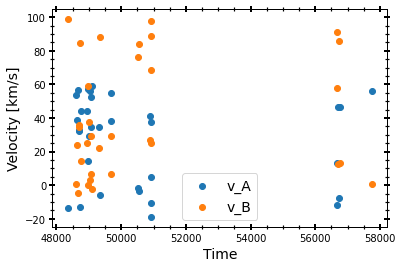

In [4]:
plt.scatter(data.mJD, data.v_A, label='v_A')
plt.scatter(data.mJD, data.v_B, label='v_B')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity [km/s]')

In [21]:
def run_tj(tb, star,chains=2, prior_size=50_000,save=False,MCMC=False):
    data           = Table()
    data['bjd']    = tb['mJD']+2_400_000
    data['rv']     = tb['v_%s'%star]
    data['rv_err'] = tb['sigma_%s'%star]
    print('mean error: %.3f km/s'%np.mean(data['rv_err']))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        
        prior = tj.JokerPrior.default(
                P_min = 63 * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = 150 * u.day,
                sigma_K0 = 100 * u.km / u.s,
                sigma_v = 100 * u.km / u.s,
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    print(joker_samples[0])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
    #ax.set_xlabel(f"BMJD$ - {data.t.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=chains)

        az.summary(trace, var_names=prior.par_names)
        print('MCMC samples...')
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        # ==== 2 body ====
        #truth = ['P','e','omega','M0','K','v0','s']
        truth = ['P','e','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)



In [22]:

prior_samples, joker_samples, mcmc_samples, trace, names = run_tj(data, 
                                                                  star='A',
                                                                  prior_size = 1_000_000, 
                                                                  chains = 2,
                                                                  save = False, 
                                                                  MCMC = True)


mean error: 1.014 km/s
<JokerSamples [e, omega, M0, s, P] (1000000 samples)>


KeyboardInterrupt: 

In [20]:
az.summary(trace, names)

/opt/miniconda3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,63.088,0.001,63.086,63.089,0.000,0.000,1765.0,2240.0,1.0
e,0.637,0.003,0.631,0.643,0.000,0.000,1963.0,2210.0,1.0
omega,1.300,0.009,1.283,1.318,0.000,0.000,2114.0,2451.0,1.0
M0,0.258,0.013,0.236,0.283,0.000,0.000,1673.0,1954.0,1.0
s,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
K,-40.514,0.092,-40.689,-40.341,0.002,0.002,1653.0,2012.0,1.0
v0,31.233,0.082,31.078,31.385,0.002,0.001,2049.0,2246.0,1.0


In [18]:
version = 2

In [19]:
# save mcmc
save_dir = '../data/claudia/mcmc_%s_%i.pickle' % (DATE, version)
with open(save_dir, 'wb') as handle:
    pickle.dump(mcmc_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save trace
save_dir = '../data/claudia/trace_%s_%i.pickle' % (DATE, version)
with open(save_dir, 'wb') as handle:
    pickle.dump(trace, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
save_dir = '../data/claudia/joker_%s_%i.hdf5'%(DATE, version)
joker_samples[0].write(save_dir, overwrite=True)

In [ ]:
ss

In [ ]:
joker

In [ ]:

corner_names = ['P', 'e', 'omega', 'M0', 'K', 'v0']


In [ ]:

fig = corner.corner(mcmc_samples.tbl.to_pandas()[corner_names], 
                            labels=corner_names,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}
                           )

# fig.savefig('../data/claudia/starB_params.png',bbox_inches='tight',dpi=200,facecolor='white')

In [25]:
joker_samples[0]

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>